In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os
import pickle

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def loadNpy(filename):
    with open(filename, "rb") as f: return np.load(f)

db = f"{os.getcwd()}/../data2/slices/gaussian-grabber/size245000-newnorm-uf/"
#db = f"{os.getcwd()}/../data2/slices/tiled-gaussian-grabber/depthTile-size243000-newnorm-uf/"
data_type = ""

In [4]:
X_train, X_val, X_test = loadNpy(db + f"{data_type}X_train.npy"), loadNpy(db + f"{data_type}X_val.npy"), loadNpy(db + f"{data_type}X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"{data_type}y_train.npy"), loadNpy(db + f"{data_type}y_val.npy"), loadNpy(db + f"{data_type}y_test.npy")

In [5]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [6]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [505]:
X_train.shape

torch.Size([1176, 245009])

In [7]:
X_train = X_train[:,:-9]
X_val = X_val[:,:-9]
X_test = X_test[:,:-9]

In [148]:
X_trval = torch.cat((X_train, X_val), 0)
y_trval = torch.cat((y_train, y_val), 0)

trval_dataset = TensorDataset(X_trval, y_trval)

In [149]:
print(X_trval.shape)

torch.Size([1569, 245009])


In [150]:
dataset_len = X_trval.shape[0]
validation_split = 0.25
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor(validation_split * dataset_len))
validation_idx = np.random.choice(indices, size=val_len, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## Defining the samplers for each phase based on the random indices:
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader = torch.utils.data.DataLoader(trval_dataset, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(trval_dataset, sampler=validation_sampler)
data_loaders = {"train": train_loader, "val": validation_loader}
data_lengths = {"train": len(train_idx), "val": val_len}

In [28]:
X_train.shape[0] + X_val.shape[0]

1569

In [7]:
batch_size = 128

In [8]:
train_iterator = DataLoader(dataset=TensorDataset(X_train, y_train),batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=TensorDataset(X_test, y_test), batch_size=batch_size,shuffle=False)

In [583]:
X_train.shape

torch.Size([1176, 245009])

In [11]:
y_train

tensor([0, 0, 1,  ..., 1, 1, 1])

In [12]:
np.mean(y_train)

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, dtype=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [10]:
np.mean(y_val)

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, dtype=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [83]:
np.mean(y_test)

0.45

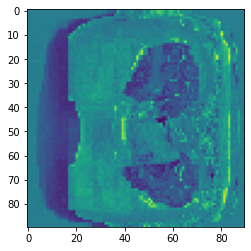

In [26]:
image = X_train[1000,:]
plt.imshow(image[:-9].reshape(90,90,60)[:,:,50])

In [107]:
for i in range(X_train.shape[0]):
    sample = X_train[i,:,:,:]
    print(sample)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3846, 0.5000, 0.3538,  ..., 0.1846, 0.2077, 0.4000],
         ...,
         [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.4135, 0.1579, 0.0451,  ..., 0.1955, 0.0075, 0.0226],
         [0.5536, 0.6071, 0.1339,  ..., 0.6071, 0.3304, 0.2321],
         ...,
         [0.1526, 0.4579, 0.7526,  ..., 0.4632, 0.4789, 0.5211],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.2500,  ..., 0.7500, 0.2500, 0.7500],
         [0.5092, 0.3926, 0.0491,  ..., 0.2393, 0.3804, 0.1043],
         [0.1364, 0.2898, 0.1420,  ..., 0.1023, 0.3580, 0.

tensor([[[0.4688, 0.3438, 0.3229,  ..., 0.3542, 0.0000, 0.4896],
         [0.1550, 0.4031, 0.3643,  ..., 0.0698, 0.1473, 0.1938],
         [0.4383, 0.2716, 0.3642,  ..., 0.1358, 0.0370, 0.2778],
         ...,
         [0.6758, 0.6593, 0.6209,  ..., 0.4615, 0.3077, 0.2363],
         [0.0476, 0.1095, 0.1286,  ..., 0.6429, 0.6143, 0.2381],
         [0.2913, 0.3386, 0.3150,  ..., 0.5512, 0.0945, 0.5512]],

        [[0.4196, 0.2411, 0.2143,  ..., 0.0893, 0.0268, 0.1429],
         [0.2477, 0.7064, 0.7798,  ..., 0.4495, 0.5596, 0.2018],
         [0.0063, 0.0188, 0.0188,  ..., 0.0625, 0.1813, 0.1562],
         ...,
         [0.3631, 0.2849, 0.3575,  ..., 0.4469, 0.4413, 0.4413],
         [0.9835, 0.8516, 0.5440,  ..., 0.2692, 0.5055, 0.5110],
         [0.3500, 0.1750, 0.1917,  ..., 0.4917, 0.0750, 0.2667]],

        [[0.0345, 0.0603, 0.1293,  ..., 0.1121, 0.3621, 0.0431],
         [0.2662, 0.4317, 0.4892,  ..., 0.1079, 0.3094, 0.1655],
         [0.0909, 0.1399, 0.3566,  ..., 0.0979, 0.1748, 0.

In [29]:
X_test.shape

(60, 343000)

In [12]:
input_size = 243540
h1_size = 800
h2_size = 800
h3_size = 600
h4_size = 400
h5_size = 100
num_classes = 2
num_epochs = 1000
batch_size = 8
learning_rate = 0.001

In [13]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1_size).to(device)
        #self.bn1 = nn.BatchNorm1d(h1_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(h1_size, h2_size).to(device)
        #self.bn2 = nn.BatchNorm1d(h2_size)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.5)
        
        #self.drop1 = nn.Dropout(p=0.1)
        #self.bn2 = nn.BatchNorm1d(h2_size)
        self.fc3 = nn.Linear(h2_size, h3_size).to(device)
        #self.bn3 = nn.BatchNorm1d(h3_size)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.5)
        
        #self.bn3 = nn.BatchNorm1d(h3_size)
        self.fc4 = nn.Linear(h3_size, h4_size).to(device)
        #self.bn4 = nn.BatchNorm1d(h4_size)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.5)
        
        #self.bn4 = nn.BatchNorm1d(h4_size)
        #self.drop2 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(h4_size, h5_size).to(device)
        #self.bn5 = nn.BatchNorm1d(h4_size)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout(p=0.5)
        
        self.fc6 = nn.Linear(h5_size, num_classes).to(device)
    
    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        #out = self.bn2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
        #out = self.bn2(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu3(out)
        out = self.drop3(out)
        #out = self.bn3(out)
        
        out = self.fc4(out)
        #out = self.bn4(out)
        out = self.relu4(out)
        out = self.drop4(out)
        
        #out = self.bn4(out)
        out = self.fc5(out)
        #out = self.bn5(out)
        out = self.relu5(out)
        out = self.drop5(out)
        
        out = self.fc6(out)
        return out

In [11]:
def eval_nn(mod, data):
    preds = []
    actual = []
    
    shape = data.dataset.tensors[0].shape[1:]
    
    mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images = images.reshape(-1,243540).to(device)
            labels = labels.to(device)
            outputs = mod(images)
            _, predicted = torch.max(outputs.data, 1)
            
            #y_pred_softmax = torch.log_softmax(outputs, dim = 1)
            #_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
            #print(y_pred_tags.shape)
            #print(labels.shape)
            correct += (predicted == labels).sum().item()
    
            total += labels.size(0)
            #correct += (predicted == labels).sum().item()
            preds.append(y_pred_tags) #predicted)
            actual.append(labels)

        print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')
    return preds, actual, correct/total

In [12]:
nn_model = NeuralNet(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [2]:
from libauc.losses import AUCMLoss, SOAPLoss, APLoss_SH
from libauc.optimizers import PESG, SOAP_ADAM, SOAP_SGD

imratio = np.mean(y_)
SEED = 123
BATCH_SIZE = 64
lr =  1e-2
weight_decay = 2e-4
margin = 0.6
beta = 0.99 # this refers to gamma for moving average in the paper
posNum = 1

loss_func = AUCMLoss(imratio=imratio)

optimizer = PESG(rn, 
                 a=loss_func.a, 
                 b=loss_func.b, 
                 alpha=loss_func.alpha, 
                 imratio=imratio, 
                 lr=lr, 
                 gamma=beta, 
                 margin=margin, 
                 weight_decay=weight_decay)

NameError: name 'minAcc' is not defined

In [13]:
nn_epochs = {}

# Train the model
total_step = len(train_iterator)
for epoch in tqdm(range(num_epochs)):
    
    correct = 0
    for i, (images, labels) in enumerate(train_iterator):  
        # Move tensors to the configured device
        #print(images.shape)
        images = images.reshape(-1,243540).to(device)
        labels = labels.to(device)
        
        # Forward pass
        #print(images.shape)
        outputs = nn_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(nn_model.parameters(), 5)
        optimizer.step()
        #print(i)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    #print(len(train_iterator))
    accuracy = 100 * correct / len(train_iterator.dataset)
    print("Accuracy = {}".format(accuracy))
    
    nn_model.val()
    nn_epochs[epoch] = {"loss": loss.item(), "train": eval_nn(nn_model, train_iterator), 
                 #"val": eval_nn(nn_model, val_iterator), "test": eval_nn(nn_model, test_iterator)}
    nn_model.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000], Step [19/19], Loss: 1.3179
Accuracy = 53.061222076416016
Epoch [2/1000], Step [19/19], Loss: 0.7835
Accuracy = 53.911563873291016
Epoch [3/1000], Step [19/19], Loss: 0.6785
Accuracy = 56.37754821777344
Epoch [4/1000], Step [19/19], Loss: 0.6513
Accuracy = 59.77891159057617
Epoch [5/1000], Step [19/19], Loss: 0.6644
Accuracy = 61.56462478637695
Epoch [6/1000], Step [19/19], Loss: 0.6601
Accuracy = 59.01360321044922
Epoch [7/1000], Step [19/19], Loss: 0.6851
Accuracy = 59.693878173828125
Epoch [8/1000], Step [19/19], Loss: 0.7047
Accuracy = 59.523807525634766
Epoch [9/1000], Step [19/19], Loss: 0.6257
Accuracy = 60.28911590576172
Epoch [10/1000], Step [19/19], Loss: 0.6711
Accuracy = 59.43877410888672
Epoch [11/1000], Step [19/19], Loss: 0.7006
Accuracy = 59.098636627197266
Epoch [12/1000], Step [19/19], Loss: 0.6937
Accuracy = 60.204078674316406
Epoch [13/1000], Step [19/19], Loss: 0.7090
Accuracy = 59.35374069213867
Epoch [14/1000], Step [19/19], Loss: 0.7435
Accuracy =

KeyboardInterrupt: 

In [ ]:
eval_nn(nn_model, val_iterator)

In [9]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [118]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=128,            
                kernel_size=4,
                stride=1,                   
                padding=2,                  
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=4),
            nn.BatchNorm2d(128),
        ).to(device)
        self.conv2 = nn.Sequential(         
            nn.Conv2d(128, 64, 4, 1, 2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(64)
        ).to(device)
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 128, 4, 1, 2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(128),
        ).to(device)
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(256),
        ).to(device)
        #"""
        #self.l5 = nn.AvgPool3d(2, 1).to(device)
        #self.l6 = nn.Linear(2, 512).to(device)
        #self.l7 = nn.Dropout3d(0.3).to(device)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 128, 4, 1, 2),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(128),
        ).to(device)
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 512, 4, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1)
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(512),
        ).to(device)
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 5, 1, 2),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(256),
        ).to(device)
        self.conv8 = nn.Sequential(         
            nn.Conv2d(256, 128, 5, 1, 2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(128),                
        ).to(device)
        """
        self.conv9 = nn.Sequential(         
            nn.Conv3d(128, 512, 5, 1, 2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm3d(512),
        ).to(device)
        self.conv10 = nn.Sequential(
            nn.Conv3d(512, 128, 5, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            #nn.MaxPool3d(2),
            nn.BatchNorm3d(128),
        ).to(device)
        self.conv11 = nn.Sequential(
            nn.Conv3d(128, 64, 5, 1, 2),
            nn.ReLU(),
        ).to(device)
        """
        
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            #nn.AdaptiveAvgPool1d(2),
            nn.Linear(8192, 2),
            nn.Sigmoid(),
        ).to(device)
        #self.out = nn.Linear(27648, 2).to(device)
        
    def forward(self, x):
        x = x.to(device)
        #print(x)
        #print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x = self.l5(x)
        #x = self.l6(x)
        #x = self.l7(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        #x = self.conv9(x)
        #x = self.conv10(x)
        #x = self.conv11(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        output = self.out(x)
        return output, x    # return x for visualization

In [119]:
from torchmetrics import ROC

def eval_cnn2d(cnn_mod, data):
    
    loader = val_iterator
    if data == "test":
        loader = test_iterator
    
    cnn_mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loader:
            images = images.reshape(-1,1,451,540).to(device)
            #images = torch.swapaxes(images, 1, 3)
            labels = labels.to(device)
            test_output, last_layer = cnn_mod(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            pred_ys = pred_ys + test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            pass
        print(f'{data} Accuracy of the model on the {total} {data} images: %.3f' % (correct/total))
        return pred_ys, labs, correct/total
    pass

In [120]:
cnn2d = CNN2D()

In [121]:
loss_func = nn.CrossEntropyLoss()  
optimizer = optim.Adam(cnn2d.parameters(), lr = 0.01, weight_decay=1e-4) 

In [106]:
from libauc.losses import AUCMLoss, SOAPLoss, APLoss_SH
from libauc.optimizers import PESG, SOAP_ADAM, SOAP_SGD

imratio = np.mean(y_trval.numpy())
SEED = 123
BATCH_SIZE = 64
lr =  #0.00
weight_decay = 2e-4
margin = 0.6
beta = 0.99 # this refers to gamma for moving average in the paper
posNum = 1

loss_func = AUCMLoss(imratio=imratio)

optimizer = PESG(cnn2d, 
                 a=loss_func.a, 
                 b=loss_func.b, 
                 alpha=loss_func.alpha, 
                 imratio=imratio, 
                 lr=lr, 
                 gamma=beta, 
                 margin=margin, 
                 weight_decay=weight_decay)

SyntaxError: invalid syntax (3508968137.py, line 7)

In [122]:
from torch.autograd import Variable

num_epochs = 1500
cnn_epochs = {}

def train(num_epochs, cnn_mod):
    cnn_epochs = {}
    
    cnn_mod.train()
        
    # Train the model
    total_step = len(data_loaders["train"].dataset)
        
    for epoch in tqdm(range(num_epochs)):
        
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        
        for phase in ["train", "val"]:
            if phase == "train":
                #optimizer = scheduler(optimizer, epoch)
                cnn_mod.train(True)
            else:
                cnn_mod.train(False)

            for i, (images, labels) in enumerate(data_loaders[phase]):

                #print(images.shape)
                images = images.reshape(-1,1,451,540).to(device)
                #images = torch.swapaxes(images, 1, 3)
                #print(images.shape)
                #images = images.reshape(-1,70,70,50, 1).to(device)
                labels = labels.to(device)
                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(images)   # batch x
                b_y = Variable(labels)   # batch y
                output = cnn_mod(b_x)[0]
                loss = loss_func(output, b_y)

                # clear gradients for this training step   
                optimizer.zero_grad()           

                if phase == "train":
                    # backpropagation, compute gradients 
                    loss.backward()    
                    # apply gradients             
                    optimizer.step() 

                pred_y = torch.max(output, 1)[1]#[1].data.squeeze()
                #print(pred_y)
                pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
                labs = labs + labels.tolist()
                total += len(labels)
                correct += (pred_y == labels).sum().item()

                #print(i)
                #if i == 18:
                #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                #    #cnn_epochs[epoch] = {"loss": loss.item(), #"train": eval_cnn2d(cnn_mod, "train"), 
                #                 #"val": eval_cnn2d(cnn_mod, "val"), "test": eval_cnn2d(cnn_mod, "test")}
                #    #cnn_mod.train()
                #    pass
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            #print(label)
            #print(p)
            cm[label, p] += 1

        print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        print(f"AUC = {roc_auc_score(labs, pred_ys)}")
        
        cnn_epochs[epoch] = {"loss": loss.item(), "acc": correct/total, 
                             "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                            "auc": roc_auc_score(labs, pred_ys)}
        
        if epoch+1 % 100 == 0:
            with open(f"{db}ep{epoch}-2dcnn-6l.pickle", "wb") as f:
                pickle.dump(cnn_epochs, f)
        
    return cnn

train(num_epochs, cnn2d)

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [1/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.815
Sensitivity = 0.05241935483870968
Specificity = 0.9576078728236185
AUC = 0.505013613831164
Epoch [2/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.841
Sensitivity = 0.0
Specificity = 0.9992429977289932
AUC = 0.4996214988644966
Epoch [3/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [4/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [5/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [6/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [7/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 image

Epoch [57/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [58/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [59/1500], Step [392/1569], Loss: 1.3126
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [60/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [61/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [62/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.728
Sensitivity = 0.17338709677419356
Specificity = 0.8319454958364875
AUC = 0.5026662963053405
Epoch [63/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity =

Epoch [113/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [114/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [115/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.460
Sensitivity = 0.5685483870967742
Specificity = 0.43981831945495836
AUC = 0.5041833532758664
Epoch [116/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.820
Sensitivity = 0.028225806451612902
Specificity = 0.9689629068887207
AUC = 0.4985943566701668
Epoch [117/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.530
Sensitivity = 0.3870967741935484
Specificity = 0.5571536714610144
AUC = 0.47212522282728137
Epoch [118/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.474
Sensitivity = 0.5685483870967742
Specificity = 0.456472

Epoch [167/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [168/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [169/1500], Step [392/1569], Loss: 1.3131
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [170/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [171/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [172/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [173/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch 

Epoch [224/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [225/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [226/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [227/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [228/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [229/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [230/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.580
Sensitivity = 0.3709677419354839
Specificity = 0.619

KeyboardInterrupt: 

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.image = nn.Sequential(
            nn.Conv2d(70, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        ).to(device)
        
        self.meta = nn.Sequential(
            nn.Linear(9, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
            #nn.Dropout(p=0.1),
        ).to(device)
        
        """
        self.combined = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(32, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(384, 256, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            #nn.Conv2d(256, 256, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
        ).to(device)
        
        
        self.image_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        """
        
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            #nn.AdaptiveAvgPool1d(2),
            nn.Linear(1568, 512),
            nn.ReLU(),
            #nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(),
            #nn.BatchNorm1d(128),
            nn.Linear(128, 2),
            nn.ReLU(),
        ).to(device)
        #self.out = nn.Linear(27648, 2).to(device)
        
    def forward(self, x, y):
        #print(x.shape)
        #print(y.shape)
        #print
        
        x = self.image(x).reshape(-1, 1536) #.flatten()
        #print(x.shape)
        y = self.meta(y).reshape(-1, 32)
        #print(x.shape)
        #print(y.shape)
        z = torch.hstack((x, y)).reshape(-1, 1568) #.reshape(1, 32, 281)
        #print(z.shape)
        #print(x.shape)
        #print(y.shape)
        ##print(z.shape)
        output = self.out(z)#.reshape(1,-1)
        return output    # return x for visualization

In [18]:
batch_size

128

In [19]:
from torchmetrics import ROC

def eval_cnn(data):
    data_stats = {}
    
    #cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loaders[data]:
            meta_data = images[:,-9:].to(device)
            image_data = images[:,:-9].reshape(-1,70,70,50).to(device)
            labels = labels.to(device)
            #print(meta_data.shape)
            #print(labels.shape)
            
            b_x = Variable(image_data)   # batch x
            b_y = Variable(meta_data)  # batch y
            output = cnn(b_x, b_y)
            #print(output)
            #print(torch.max(output, 1))
            #images = images.reshape(-1,70,70,50, 1).to(device)
            #images = torch.swapaxes(images, 1, 3)
            #labels = labels.to(device)
            #test_output, last_layer = cnn_mod(images)
            pred_y = torch.max(output, 1)[1].data.squeeze()
            pred_ys = pred_ys + pred_y.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            pass
        
        
        print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            #print(label)
            #print(p)
            #print(p)
            cm[label, p] += 1

        print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        print(f"AUC = {roc_auc_score(labs, pred_ys)}")
        
        data_stats = {"acc": correct/total, "sens": cm[1,1]/(cm[1,1] + cm[1,0]), 
                      "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                     "auc": roc_auc_score(labs, pred_ys)}
        
        #cnn_epochs[epoch] = {"loss": loss.item(), "acc": correct/total, 
         #                    "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
         #                   "auc": roc_auc_score(labs, pred_ys)}
    #cnn_mod.train()
    
    return data_stats
    #pass

In [50]:
cnn = CNN()
#print(cnn)

In [51]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [52]:
#optimizer = optim.Adam(cnn.parameters(), lr=0.001)
optimizer = optim.SGD(cnn.parameters(), 0.001, momentum=0.3)
#optimizer = optim.SGD(cnn.parameters(), 
            #          lr = 0.001, momentum=0.9)#weight_decay=1e-6)
sched_type = ""
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.3
    nesterov: False
    weight_decay: 0
)

In [37]:
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80,120,170,220,270], gamma=0.1)
sched_type = "12"

In [53]:
swa_model = torch.optim.swa_utils.AveragedModel(cnn)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
swa_start = 160
swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr=0.05)
sched_type = "swa"

In [54]:
from torch.autograd import Variable

num_epochs = 1500
cnn_epochs = {}

def train(num_epochs, cnn):
    
    cnn.train()
        
    # Train the model
        
    for epoch in tqdm(range(num_epochs)):
        cnn_epochs[epoch] = {}
        
        for phase in ["train", "val", "test"]:
            total_step = len(loaders[phase].dataset)
            correct = 0
            total = 0
            pred_ys = []
            labs = []
            
            if phase == "train":
                #optimizer = scheduler(optimizer, epoch)
                cnn.train(True)
            else:
                cnn.train(False)
            
            for i, (images, labels) in enumerate(loaders[phase]):

                meta_data = images[:,-9:].to(device)
                image_data = images[:,:-9].reshape(-1,70,70,50).to(device)
                #images = torch.swapaxes(images, 1, 3)

                labels = labels.to(device)
                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(image_data)   # batch x
                b_y = Variable(meta_data)
                b_z = Variable(labels)   # batch y
                output = cnn(b_x, b_y)
                #print(output)
                loss = loss_func(output, b_z)

                # clear gradients for this training step   
                optimizer.zero_grad()           

                if phase == "train":
                    # backpropagation, compute gradients 
                    loss.backward()    
                    # apply gradients             
                    optimizer.step()
                    #torch.optim.swa_utils.update_bn(loaders["train"], swa_model)
                #else:
                #    output = swa_model(b_x, b_y)
                #    loss = loss_func(output, b_z)
                #    print(loss)
                
                pred_y = torch.max(output, 1)[1]#[1].data.squeeze()
                #print(pred_y)
                pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
                labs = labs + labels.tolist()
                total += len(labels)
                correct += (pred_y == labels).sum().item()
                
            print ('Phase {} Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(phase, epoch+1, num_epochs, total, total_step, loss.item()))
            print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

            cm = np.zeros((2,2))
            for i, p in enumerate(pred_ys):
                label = labs[i]
                #print(label)
                #print(p)
                cm[label, p] += 1

            print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
            print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
            print(f"AUC = {roc_auc_score(labs, pred_ys)}")

            #cnn.train(False)
            #cnn.eval(True)
            cnn_epochs[epoch][phase] = {"loss": loss.item(), "acc": correct/total, 
                                 "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                                "auc": roc_auc_score(labs, pred_ys)}
            #cnn.eval(False)
            #cnn.train(True)
        print()
        
        if sched_type == "swa":
            if epoch > swa_start:
                swa_model.update_parameters(cnn)
                swa_scheduler.step()
            else:
                scheduler.step()
        elif sched_type == "12":         
            scheduler1.step()
            scheduler2.step()
    
        #torch.optim.swa_utils.update_bn(loaders["train"], swa_model)

        if epoch+1 % 100 == 0:
            with open(f"{db}ep{epoch}-3dcnn-6l.pickle", "wb") as f:
                pickle.dump(cnn_epochs, f)
    pass

train(num_epochs, cnn)#, X_trval)

  0%|          | 0/1500 [00:00<?, ?it/s]

Phase train Epoch [1/1500], Step [1176/1176], Loss: 0.6897
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [1/1500], Step [393/393], Loss: 0.6851
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [1/1500], Step [393/393], Loss: 0.6917
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [2/1500], Step [1176/1176], Loss: 0.6892
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [2/1500], Step [393/393], Loss: 0.6841
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [2/1500], Step [393/393], Loss: 0.6916
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [3/1500], Step [1176/1176], Loss: 0.6888
Accuracy of the model on the 1176 image

Phase test Epoch [19/1500], Step [393/393], Loss: 0.6892
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [20/1500], Step [1176/1176], Loss: 0.6825
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [20/1500], Step [393/393], Loss: 0.6678
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [20/1500], Step [393/393], Loss: 0.6891
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [21/1500], Step [1176/1176], Loss: 0.6821
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [21/1500], Step [393/393], Loss: 0.6671
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [21/1500], Step [393/393], Loss: 0.6890
Accuracy of the model on the 393 im

Phase train Epoch [38/1500], Step [1176/1176], Loss: 0.6791
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [38/1500], Step [393/393], Loss: 0.6593
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [38/1500], Step [393/393], Loss: 0.6881
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [39/1500], Step [1176/1176], Loss: 0.6790
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [39/1500], Step [393/393], Loss: 0.6590
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [39/1500], Step [393/393], Loss: 0.6881
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [40/1500], Step [1176/1176], Loss: 0.6788
Accuracy of the model on the 117

Phase test Epoch [56/1500], Step [393/393], Loss: 0.6876
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [57/1500], Step [1176/1176], Loss: 0.6769
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [57/1500], Step [393/393], Loss: 0.6535
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [57/1500], Step [393/393], Loss: 0.6876
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [58/1500], Step [1176/1176], Loss: 0.6768
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [58/1500], Step [393/393], Loss: 0.6532
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [58/1500], Step [393/393], Loss: 0.6876
Accuracy of the model on the 393 im

Phase train Epoch [75/1500], Step [1176/1176], Loss: 0.6753
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [75/1500], Step [393/393], Loss: 0.6488
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [75/1500], Step [393/393], Loss: 0.6873
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [76/1500], Step [1176/1176], Loss: 0.6752
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [76/1500], Step [393/393], Loss: 0.6485
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [76/1500], Step [393/393], Loss: 0.6873
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [77/1500], Step [1176/1176], Loss: 0.6751
Accuracy of the model on the 117

Phase test Epoch [93/1500], Step [393/393], Loss: 0.6871
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [94/1500], Step [1176/1176], Loss: 0.6738
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [94/1500], Step [393/393], Loss: 0.6446
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [94/1500], Step [393/393], Loss: 0.6871
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [95/1500], Step [1176/1176], Loss: 0.6738
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [95/1500], Step [393/393], Loss: 0.6444
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [95/1500], Step [393/393], Loss: 0.6871
Accuracy of the model on the 393 im

Phase test Epoch [111/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [112/1500], Step [1176/1176], Loss: 0.6727
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [112/1500], Step [393/393], Loss: 0.6413
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [112/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [113/1500], Step [1176/1176], Loss: 0.6727
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [113/1500], Step [393/393], Loss: 0.6411
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [113/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the

Phase test Epoch [129/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [130/1500], Step [1176/1176], Loss: 0.6719
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [130/1500], Step [393/393], Loss: 0.6386
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [130/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [131/1500], Step [1176/1176], Loss: 0.6718
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [131/1500], Step [393/393], Loss: 0.6384
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [131/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the

Phase test Epoch [147/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [148/1500], Step [1176/1176], Loss: 0.6712
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [148/1500], Step [393/393], Loss: 0.6364
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [148/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [149/1500], Step [1176/1176], Loss: 0.6711
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [149/1500], Step [393/393], Loss: 0.6362
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [149/1500], Step [393/393], Loss: 0.6870
Accuracy of the model on the

Phase test Epoch [165/1500], Step [393/393], Loss: 0.6871
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [166/1500], Step [1176/1176], Loss: 0.6689
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [166/1500], Step [393/393], Loss: 0.6284
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [166/1500], Step [393/393], Loss: 0.6872
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [167/1500], Step [1176/1176], Loss: 0.6678
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [167/1500], Step [393/393], Loss: 0.6243
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [167/1500], Step [393/393], Loss: 0.6874
Accuracy of the model on the

Phase test Epoch [183/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [184/1500], Step [1176/1176], Loss: 0.6621
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [184/1500], Step [393/393], Loss: 0.5940
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [184/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [185/1500], Step [1176/1176], Loss: 0.6621
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [185/1500], Step [393/393], Loss: 0.5938
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [185/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the

Phase test Epoch [201/1500], Step [393/393], Loss: 0.6933
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [202/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [202/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [202/1500], Step [393/393], Loss: 0.6933
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [203/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [203/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [203/1500], Step [393/393], Loss: 0.6933
Accuracy of the model on the

Phase test Epoch [219/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [220/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [220/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [220/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [221/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [221/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [221/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the

Phase test Epoch [237/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [238/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [238/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [238/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [239/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [239/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [239/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the

Phase test Epoch [255/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [256/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [256/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [256/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [257/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [257/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [257/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the

Phase test Epoch [273/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [274/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [274/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [274/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [275/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [275/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [275/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the

Phase test Epoch [291/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [292/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [292/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [292/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [293/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [293/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [293/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the

Phase test Epoch [309/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [310/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [310/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [310/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [311/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [311/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [311/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the

Phase test Epoch [327/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [328/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [328/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [328/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [329/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [329/1500], Step [393/393], Loss: 0.5932
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [329/1500], Step [393/393], Loss: 0.6932
Accuracy of the model on the

Phase test Epoch [345/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [346/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [346/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [346/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [347/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [347/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [347/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the

Phase test Epoch [363/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [364/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [364/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [364/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [365/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [365/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [365/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the

Phase test Epoch [381/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [382/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [382/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [382/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [383/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [383/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [383/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the

Phase test Epoch [399/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [400/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [400/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [400/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [401/1500], Step [1176/1176], Loss: 0.6620
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [401/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [401/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the

Phase test Epoch [417/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [418/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [418/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [418/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [419/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [419/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [419/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the

Phase test Epoch [435/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [436/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [436/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [436/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [437/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [437/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [437/1500], Step [393/393], Loss: 0.6931
Accuracy of the model on the

Phase test Epoch [453/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [454/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [454/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [454/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [455/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [455/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [455/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the

Phase test Epoch [471/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [472/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [472/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [472/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [473/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [473/1500], Step [393/393], Loss: 0.5933
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [473/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the

Phase test Epoch [489/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [490/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [490/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [490/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [491/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [491/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [491/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the

Phase test Epoch [507/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [508/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [508/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [508/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [509/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [509/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [509/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the

Phase test Epoch [525/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [526/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [526/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [526/1500], Step [393/393], Loss: 0.6930
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [527/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [527/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [527/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the

Phase test Epoch [543/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [544/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [544/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [544/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [545/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [545/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [545/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the

Phase test Epoch [561/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [562/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [562/1500], Step [393/393], Loss: 0.5934
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [562/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [563/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [563/1500], Step [393/393], Loss: 0.5935
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [563/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the

Phase test Epoch [579/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [580/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [580/1500], Step [393/393], Loss: 0.5935
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [580/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [581/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [581/1500], Step [393/393], Loss: 0.5935
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [581/1500], Step [393/393], Loss: 0.6929
Accuracy of the model on the

Phase test Epoch [597/1500], Step [393/393], Loss: 0.6928
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [598/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [598/1500], Step [393/393], Loss: 0.5935
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [598/1500], Step [393/393], Loss: 0.6928
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [599/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [599/1500], Step [393/393], Loss: 0.5935
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [599/1500], Step [393/393], Loss: 0.6928
Accuracy of the model on the

Phase test Epoch [615/1500], Step [393/393], Loss: 0.6928
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [616/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [616/1500], Step [393/393], Loss: 0.5935
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [616/1500], Step [393/393], Loss: 0.6928
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [617/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [617/1500], Step [393/393], Loss: 0.5935
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [617/1500], Step [393/393], Loss: 0.6928
Accuracy of the model on the

Phase test Epoch [633/1500], Step [393/393], Loss: 0.6927
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [634/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [634/1500], Step [393/393], Loss: 0.5936
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [634/1500], Step [393/393], Loss: 0.6927
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [635/1500], Step [1176/1176], Loss: 0.6619
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [635/1500], Step [393/393], Loss: 0.5936
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [635/1500], Step [393/393], Loss: 0.6927
Accuracy of the model on the

Phase test Epoch [651/1500], Step [393/393], Loss: 0.6927
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [652/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [652/1500], Step [393/393], Loss: 0.5936
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [652/1500], Step [393/393], Loss: 0.6927
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [653/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [653/1500], Step [393/393], Loss: 0.5936
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [653/1500], Step [393/393], Loss: 0.6927
Accuracy of the model on the

Phase test Epoch [669/1500], Step [393/393], Loss: 0.6926
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [670/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [670/1500], Step [393/393], Loss: 0.5937
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [670/1500], Step [393/393], Loss: 0.6926
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [671/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [671/1500], Step [393/393], Loss: 0.5937
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [671/1500], Step [393/393], Loss: 0.6926
Accuracy of the model on the

Phase test Epoch [687/1500], Step [393/393], Loss: 0.6926
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [688/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [688/1500], Step [393/393], Loss: 0.5937
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [688/1500], Step [393/393], Loss: 0.6926
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [689/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [689/1500], Step [393/393], Loss: 0.5937
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [689/1500], Step [393/393], Loss: 0.6926
Accuracy of the model on the

Phase test Epoch [705/1500], Step [393/393], Loss: 0.6925
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [706/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [706/1500], Step [393/393], Loss: 0.5938
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [706/1500], Step [393/393], Loss: 0.6925
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [707/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [707/1500], Step [393/393], Loss: 0.5938
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [707/1500], Step [393/393], Loss: 0.6925
Accuracy of the model on the

Phase test Epoch [723/1500], Step [393/393], Loss: 0.6924
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [724/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [724/1500], Step [393/393], Loss: 0.5939
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [724/1500], Step [393/393], Loss: 0.6924
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [725/1500], Step [1176/1176], Loss: 0.6618
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [725/1500], Step [393/393], Loss: 0.5939
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [725/1500], Step [393/393], Loss: 0.6924
Accuracy of the model on the

Phase test Epoch [741/1500], Step [393/393], Loss: 0.6923
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [742/1500], Step [1176/1176], Loss: 0.6617
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [742/1500], Step [393/393], Loss: 0.5940
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [742/1500], Step [393/393], Loss: 0.6923
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [743/1500], Step [1176/1176], Loss: 0.6617
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [743/1500], Step [393/393], Loss: 0.5940
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [743/1500], Step [393/393], Loss: 0.6923
Accuracy of the model on the

Phase test Epoch [759/1500], Step [393/393], Loss: 0.6922
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [760/1500], Step [1176/1176], Loss: 0.6617
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [760/1500], Step [393/393], Loss: 0.5941
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [760/1500], Step [393/393], Loss: 0.6922
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [761/1500], Step [1176/1176], Loss: 0.6617
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [761/1500], Step [393/393], Loss: 0.5941
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [761/1500], Step [393/393], Loss: 0.6922
Accuracy of the model on the

Phase test Epoch [777/1500], Step [393/393], Loss: 0.6921
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [778/1500], Step [1176/1176], Loss: 0.6617
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [778/1500], Step [393/393], Loss: 0.5942
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [778/1500], Step [393/393], Loss: 0.6921
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [779/1500], Step [1176/1176], Loss: 0.6617
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [779/1500], Step [393/393], Loss: 0.5942
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [779/1500], Step [393/393], Loss: 0.6921
Accuracy of the model on the

Phase test Epoch [795/1500], Step [393/393], Loss: 0.6919
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [796/1500], Step [1176/1176], Loss: 0.6616
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [796/1500], Step [393/393], Loss: 0.5943
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [796/1500], Step [393/393], Loss: 0.6919
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [797/1500], Step [1176/1176], Loss: 0.6616
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [797/1500], Step [393/393], Loss: 0.5944
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [797/1500], Step [393/393], Loss: 0.6919
Accuracy of the model on the

Phase test Epoch [813/1500], Step [393/393], Loss: 0.6917
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [814/1500], Step [1176/1176], Loss: 0.6616
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [814/1500], Step [393/393], Loss: 0.5945
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [814/1500], Step [393/393], Loss: 0.6917
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [815/1500], Step [1176/1176], Loss: 0.6615
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [815/1500], Step [393/393], Loss: 0.5945
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [815/1500], Step [393/393], Loss: 0.6917
Accuracy of the model on the

Phase test Epoch [831/1500], Step [393/393], Loss: 0.6915
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [832/1500], Step [1176/1176], Loss: 0.6615
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [832/1500], Step [393/393], Loss: 0.5948
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [832/1500], Step [393/393], Loss: 0.6915
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [833/1500], Step [1176/1176], Loss: 0.6615
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [833/1500], Step [393/393], Loss: 0.5948
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [833/1500], Step [393/393], Loss: 0.6915
Accuracy of the model on the

Phase test Epoch [849/1500], Step [393/393], Loss: 0.6912
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [850/1500], Step [1176/1176], Loss: 0.6614
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [850/1500], Step [393/393], Loss: 0.5951
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [850/1500], Step [393/393], Loss: 0.6912
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [851/1500], Step [1176/1176], Loss: 0.6614
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [851/1500], Step [393/393], Loss: 0.5951
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [851/1500], Step [393/393], Loss: 0.6912
Accuracy of the model on the

Phase test Epoch [867/1500], Step [393/393], Loss: 0.6908
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [868/1500], Step [1176/1176], Loss: 0.6613
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [868/1500], Step [393/393], Loss: 0.5955
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [868/1500], Step [393/393], Loss: 0.6908
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [869/1500], Step [1176/1176], Loss: 0.6613
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [869/1500], Step [393/393], Loss: 0.5955
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [869/1500], Step [393/393], Loss: 0.6908
Accuracy of the model on the

Phase test Epoch [885/1500], Step [393/393], Loss: 0.6904
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [886/1500], Step [1176/1176], Loss: 0.6611
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [886/1500], Step [393/393], Loss: 0.5960
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [886/1500], Step [393/393], Loss: 0.6904
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [887/1500], Step [1176/1176], Loss: 0.6611
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [887/1500], Step [393/393], Loss: 0.5960
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [887/1500], Step [393/393], Loss: 0.6903
Accuracy of the model on the

Phase test Epoch [903/1500], Step [393/393], Loss: 0.6898
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [904/1500], Step [1176/1176], Loss: 0.6609
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [904/1500], Step [393/393], Loss: 0.5966
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [904/1500], Step [393/393], Loss: 0.6898
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [905/1500], Step [1176/1176], Loss: 0.6609
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [905/1500], Step [393/393], Loss: 0.5967
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [905/1500], Step [393/393], Loss: 0.6897
Accuracy of the model on the

Phase test Epoch [921/1500], Step [393/393], Loss: 0.6886
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [922/1500], Step [1176/1176], Loss: 0.6605
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [922/1500], Step [393/393], Loss: 0.5984
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [922/1500], Step [393/393], Loss: 0.6885
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [923/1500], Step [1176/1176], Loss: 0.6605
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [923/1500], Step [393/393], Loss: 0.5986
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [923/1500], Step [393/393], Loss: 0.6884
Accuracy of the model on the

Phase test Epoch [939/1500], Step [393/393], Loss: 0.6871
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [940/1500], Step [1176/1176], Loss: 0.6600
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [940/1500], Step [393/393], Loss: 0.6006
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [940/1500], Step [393/393], Loss: 0.6869
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [941/1500], Step [1176/1176], Loss: 0.6599
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [941/1500], Step [393/393], Loss: 0.6006
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [941/1500], Step [393/393], Loss: 0.6869
Accuracy of the model on the

Phase test Epoch [957/1500], Step [393/393], Loss: 0.6853
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [958/1500], Step [1176/1176], Loss: 0.6590
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [958/1500], Step [393/393], Loss: 0.6034
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [958/1500], Step [393/393], Loss: 0.6852
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [959/1500], Step [1176/1176], Loss: 0.6590
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [959/1500], Step [393/393], Loss: 0.6038
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [959/1500], Step [393/393], Loss: 0.6850
Accuracy of the model on the

Phase test Epoch [975/1500], Step [393/393], Loss: 0.6832
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [976/1500], Step [1176/1176], Loss: 0.6576
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [976/1500], Step [393/393], Loss: 0.6077
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [976/1500], Step [393/393], Loss: 0.6831
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [977/1500], Step [1176/1176], Loss: 0.6575
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [977/1500], Step [393/393], Loss: 0.6079
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [977/1500], Step [393/393], Loss: 0.6830
Accuracy of the model on the

Phase test Epoch [993/1500], Step [393/393], Loss: 0.6813
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [994/1500], Step [1176/1176], Loss: 0.6549
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [994/1500], Step [393/393], Loss: 0.6132
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [994/1500], Step [393/393], Loss: 0.6812
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [995/1500], Step [1176/1176], Loss: 0.6546
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [995/1500], Step [393/393], Loss: 0.6135
Accuracy of the model on the 393 images: 0.595
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase test Epoch [995/1500], Step [393/393], Loss: 0.6811
Accuracy of the model on the

Phase test Epoch [1011/1500], Step [393/393], Loss: 0.6754
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [1012/1500], Step [1176/1176], Loss: 0.6323
Accuracy of the model on the 1176 images: 0.610
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5
Phase val Epoch [1012/1500], Step [393/393], Loss: 0.6223
Accuracy of the model on the 393 images: 0.598
Sensitivity = 1.0
Specificity = 0.006289308176100629
AUC = 0.5031446540880503
Phase test Epoch [1012/1500], Step [393/393], Loss: 0.6750
Accuracy of the model on the 393 images: 0.588
Sensitivity = 1.0
Specificity = 0.0
AUC = 0.5

Phase train Epoch [1013/1500], Step [1176/1176], Loss: 0.6270
Accuracy of the model on the 1176 images: 0.612
Sensitivity = 0.99860529986053
Specificity = 0.008714596949891068
AUC = 0.5036599484052106
Phase val Epoch [1013/1500], Step [393/393], Loss: 0.6248
Accuracy of the model on the 393 images: 0.601
Sensitivity = 1.0
Specificity = 0.012578616352201

Phase train Epoch [1026/1500], Step [1176/1176], Loss: 0.5584
Accuracy of the model on the 1176 images: 0.629
Sensitivity = 0.8410041841004184
Specificity = 0.2984749455337691
AUC = 0.5697395648170938
Phase val Epoch [1026/1500], Step [393/393], Loss: 0.6553
Accuracy of the model on the 393 images: 0.618
Sensitivity = 0.9273504273504274
Specificity = 0.16352201257861634
AUC = 0.5454362199645219
Phase test Epoch [1026/1500], Step [393/393], Loss: 0.6607
Accuracy of the model on the 393 images: 0.611
Sensitivity = 0.9393939393939394
Specificity = 0.1419753086419753
AUC = 0.5406846240179574

Phase train Epoch [1027/1500], Step [1176/1176], Loss: 0.5554
Accuracy of the model on the 1176 images: 0.623
Sensitivity = 0.8256624825662483
Specificity = 0.30718954248366015
AUC = 0.5664260125249542
Phase val Epoch [1027/1500], Step [393/393], Loss: 0.6300
Accuracy of the model on the 393 images: 0.601
Sensitivity = 0.9487179487179487
Specificity = 0.0880503144654088
AUC = 0.5183841315916787
Phase 

Phase train Epoch [1040/1500], Step [1176/1176], Loss: 0.4812
Accuracy of the model on the 1176 images: 0.660
Sensitivity = 0.7656903765690377
Specificity = 0.49455337690631807
AUC = 0.6301218767376779
Phase val Epoch [1040/1500], Step [393/393], Loss: 0.6716
Accuracy of the model on the 393 images: 0.626
Sensitivity = 0.8717948717948718
Specificity = 0.2641509433962264
AUC = 0.5679729075955491
Phase test Epoch [1040/1500], Step [393/393], Loss: 0.6274
Accuracy of the model on the 393 images: 0.631
Sensitivity = 0.8961038961038961
Specificity = 0.25308641975308643
AUC = 0.5745951579284913

Phase train Epoch [1041/1500], Step [1176/1176], Loss: 0.4867
Accuracy of the model on the 1176 images: 0.644
Sensitivity = 0.7559274755927475
Specificity = 0.4684095860566449
AUC = 0.6121685308246962
Phase val Epoch [1041/1500], Step [393/393], Loss: 0.6211
Accuracy of the model on the 393 images: 0.616
Sensitivity = 0.9487179487179487
Specificity = 0.12578616352201258
AUC = 0.5372520561199806
Phase

Phase train Epoch [1054/1500], Step [1176/1176], Loss: 0.4214
Accuracy of the model on the 1176 images: 0.662
Sensitivity = 0.796373779637378
Specificity = 0.45098039215686275
AUC = 0.6236770858971203
Phase val Epoch [1054/1500], Step [393/393], Loss: 0.6689
Accuracy of the model on the 393 images: 0.634
Sensitivity = 0.8589743589743589
Specificity = 0.3018867924528302
AUC = 0.5804305757135946
Phase test Epoch [1054/1500], Step [393/393], Loss: 0.6195
Accuracy of the model on the 393 images: 0.626
Sensitivity = 0.8268398268398268
Specificity = 0.3395061728395062
AUC = 0.5831729998396665

Phase train Epoch [1055/1500], Step [1176/1176], Loss: 0.3667
Accuracy of the model on the 1176 images: 0.731
Sensitivity = 0.8312412831241283
Specificity = 0.5751633986928104
AUC = 0.7032023409084693
Phase val Epoch [1055/1500], Step [393/393], Loss: 0.8617
Accuracy of the model on the 393 images: 0.575
Sensitivity = 0.5384615384615384
Specificity = 0.6289308176100629
AUC = 0.5836961780358008
Phase te

Phase train Epoch [1068/1500], Step [1176/1176], Loss: 0.2432
Accuracy of the model on the 1176 images: 0.729
Sensitivity = 0.8535564853556485
Specificity = 0.5337690631808278
AUC = 0.6936627742682382
Phase val Epoch [1068/1500], Step [393/393], Loss: 0.7809
Accuracy of the model on the 393 images: 0.590
Sensitivity = 0.7094017094017094
Specificity = 0.41509433962264153
AUC = 0.5622480245121755
Phase test Epoch [1068/1500], Step [393/393], Loss: 0.3755
Accuracy of the model on the 393 images: 0.628
Sensitivity = 0.6883116883116883
Specificity = 0.5432098765432098
AUC = 0.615760782427449

Phase train Epoch [1069/1500], Step [1176/1176], Loss: 0.2248
Accuracy of the model on the 1176 images: 0.784
Sensitivity = 0.8423988842398884
Specificity = 0.6928104575163399
AUC = 0.7676046708781141
Phase val Epoch [1069/1500], Step [393/393], Loss: 0.8964
Accuracy of the model on the 393 images: 0.601
Sensitivity = 0.7606837606837606
Specificity = 0.36477987421383645
AUC = 0.5627318174487985
Phase t

Phase train Epoch [1082/1500], Step [1176/1176], Loss: 0.3132
Accuracy of the model on the 1176 images: 0.703
Sensitivity = 0.7866108786610879
Specificity = 0.5729847494553377
AUC = 0.6797978140582128
Phase val Epoch [1082/1500], Step [393/393], Loss: 0.8516
Accuracy of the model on the 393 images: 0.578
Sensitivity = 0.8162393162393162
Specificity = 0.22641509433962265
AUC = 0.5213272052894694
Phase test Epoch [1082/1500], Step [393/393], Loss: 0.7004
Accuracy of the model on the 393 images: 0.616
Sensitivity = 0.8354978354978355
Specificity = 0.30246913580246915
AUC = 0.5689834856501523

Phase train Epoch [1083/1500], Step [1176/1176], Loss: 0.1633
Accuracy of the model on the 1176 images: 0.816
Sensitivity = 0.899581589958159
Specificity = 0.6862745098039216
AUC = 0.7929280498810403
Phase val Epoch [1083/1500], Step [393/393], Loss: 1.1689
Accuracy of the model on the 393 images: 0.542
Sensitivity = 0.5256410256410257
Specificity = 0.5660377358490566
AUC = 0.5458393807450411
Phase t

Phase train Epoch [1096/1500], Step [1176/1176], Loss: 0.0274
Accuracy of the model on the 1176 images: 0.902
Sensitivity = 0.9135285913528591
Specificity = 0.8845315904139434
AUC = 0.8990300908834011
Phase val Epoch [1096/1500], Step [393/393], Loss: 0.9770
Accuracy of the model on the 393 images: 0.570
Sensitivity = 0.7478632478632479
Specificity = 0.3081761006289308
AUC = 0.5280196742460894
Phase test Epoch [1096/1500], Step [393/393], Loss: 0.9913
Accuracy of the model on the 393 images: 0.601
Sensitivity = 0.7445887445887446
Specificity = 0.3950617283950617
AUC = 0.5698252364919032

Phase train Epoch [1097/1500], Step [1176/1176], Loss: 0.0724
Accuracy of the model on the 1176 images: 0.840
Sensitivity = 0.900976290097629
Specificity = 0.7450980392156863
AUC = 0.8230371646566577
Phase val Epoch [1097/1500], Step [393/393], Loss: 0.7802
Accuracy of the model on the 393 images: 0.557
Sensitivity = 0.7521367521367521
Specificity = 0.27044025157232704
AUC = 0.5112885018545396
Phase te

Phase train Epoch [1110/1500], Step [1176/1176], Loss: 0.0066
Accuracy of the model on the 1176 images: 0.987
Sensitivity = 0.9902370990237099
Specificity = 0.9825708061002179
AUC = 0.9864039525619639
Phase val Epoch [1110/1500], Step [393/393], Loss: 1.5080
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6452991452991453
Specificity = 0.3710691823899371
AUC = 0.5081841638445412
Phase test Epoch [1110/1500], Step [393/393], Loss: 1.8123
Accuracy of the model on the 393 images: 0.578
Sensitivity = 0.6926406926406926
Specificity = 0.41358024691358025
AUC = 0.5531104697771364

Phase train Epoch [1111/1500], Step [1176/1176], Loss: 0.0024
Accuracy of the model on the 1176 images: 0.987
Sensitivity = 0.9888423988842399
Specificity = 0.9847494553376906
AUC = 0.9867959271109653
Phase val Epoch [1111/1500], Step [393/393], Loss: 1.6334
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.594017094017094
Specificity = 0.44025157232704404
AUC = 0.517134333172069
Phase te

Phase test Epoch [1124/1500], Step [393/393], Loss: 3.2253
Accuracy of the model on the 393 images: 0.578
Sensitivity = 0.7359307359307359
Specificity = 0.35185185185185186
AUC = 0.5438912938912939

Phase train Epoch [1125/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1125/1500], Step [393/393], Loss: 3.5017
Accuracy of the model on the 393 images: 0.539
Sensitivity = 0.688034188034188
Specificity = 0.32075471698113206
AUC = 0.50439445250766
Phase test Epoch [1125/1500], Step [393/393], Loss: 3.2515
Accuracy of the model on the 393 images: 0.578
Sensitivity = 0.7359307359307359
Specificity = 0.35185185185185186
AUC = 0.5438912938912939

Phase train Epoch [1126/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1126/1500], Step [393/393], Loss: 3.5497
Accuracy of the model on the 393 image

Phase test Epoch [1139/1500], Step [393/393], Loss: 3.5404
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7272727272727273
Specificity = 0.3765432098765432
AUC = 0.5519079685746352

Phase train Epoch [1140/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1140/1500], Step [393/393], Loss: 3.9734
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6923076923076923
Specificity = 0.3018867924528302
AUC = 0.49709724238026126
Phase test Epoch [1140/1500], Step [393/393], Loss: 3.5562
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7272727272727273
Specificity = 0.3765432098765432
AUC = 0.5519079685746352

Phase train Epoch [1141/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1141/1500], Step [393/393], Loss: 3.9955
Accuracy of the model on the 393 imag

Phase test Epoch [1154/1500], Step [393/393], Loss: 3.7332
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7272727272727273
Specificity = 0.3765432098765432
AUC = 0.5519079685746352

Phase train Epoch [1155/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1155/1500], Step [393/393], Loss: 4.2314
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1155/1500], Step [393/393], Loss: 3.7454
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7272727272727273
Specificity = 0.3765432098765432
AUC = 0.5519079685746352

Phase train Epoch [1156/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1156/1500], Step [393/393], Loss: 4.2471
Accuracy of the model on the 393 ima

Phase test Epoch [1169/1500], Step [393/393], Loss: 3.8814
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7272727272727273
Specificity = 0.38271604938271603
AUC = 0.5549943883277217

Phase train Epoch [1170/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1170/1500], Step [393/393], Loss: 4.4130
Accuracy of the model on the 393 images: 0.529
Sensitivity = 0.6923076923076923
Specificity = 0.2893081761006289
AUC = 0.49080793420416063
Phase test Epoch [1170/1500], Step [393/393], Loss: 3.8904
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7272727272727273
Specificity = 0.3765432098765432
AUC = 0.5519079685746352

Phase train Epoch [1171/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1171/1500], Step [393/393], Loss: 4.4230
Accuracy of the model on the 393 ima

Phase test Epoch [1184/1500], Step [393/393], Loss: 4.0002
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7316017316017316
Specificity = 0.37037037037037035
AUC = 0.5509860509860509

Phase train Epoch [1185/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1185/1500], Step [393/393], Loss: 4.5458
Accuracy of the model on the 393 images: 0.529
Sensitivity = 0.6923076923076923
Specificity = 0.2893081761006289
AUC = 0.49080793420416063
Phase test Epoch [1185/1500], Step [393/393], Loss: 4.0072
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7316017316017316
Specificity = 0.37037037037037035
AUC = 0.5509860509860509

Phase train Epoch [1186/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1186/1500], Step [393/393], Loss: 4.5527
Accuracy of the model on the 393 im

Phase test Epoch [1199/1500], Step [393/393], Loss: 4.0987
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7316017316017316
Specificity = 0.37037037037037035
AUC = 0.5509860509860509

Phase train Epoch [1200/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1200/1500], Step [393/393], Loss: 4.6519
Accuracy of the model on the 393 images: 0.529
Sensitivity = 0.6923076923076923
Specificity = 0.2893081761006289
AUC = 0.49080793420416063
Phase test Epoch [1200/1500], Step [393/393], Loss: 4.1050
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7316017316017316
Specificity = 0.37037037037037035
AUC = 0.5509860509860509

Phase train Epoch [1201/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1201/1500], Step [393/393], Loss: 4.6583
Accuracy of the model on the 393 im

Phase test Epoch [1214/1500], Step [393/393], Loss: 4.1810
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7359307359307359
Specificity = 0.36419753086419754
AUC = 0.5500641333974666

Phase train Epoch [1215/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1215/1500], Step [393/393], Loss: 4.7412
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1215/1500], Step [393/393], Loss: 4.1871
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7359307359307359
Specificity = 0.36419753086419754
AUC = 0.5500641333974666

Phase train Epoch [1216/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1216/1500], Step [393/393], Loss: 4.7475
Accuracy of the model on the 393 i

Phase test Epoch [1229/1500], Step [393/393], Loss: 4.2522
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1230/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1230/1500], Step [393/393], Loss: 4.8208
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1230/1500], Step [393/393], Loss: 4.2568
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1231/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1231/1500], Step [393/393], Loss: 4.8260
Accuracy of the model on the 393 i

Phase test Epoch [1244/1500], Step [393/393], Loss: 4.3154
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1245/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1245/1500], Step [393/393], Loss: 4.8913
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1245/1500], Step [393/393], Loss: 4.3192
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1246/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1246/1500], Step [393/393], Loss: 4.8954
Accuracy of the model on the 393 i

Phase test Epoch [1259/1500], Step [393/393], Loss: 4.3719
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1260/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1260/1500], Step [393/393], Loss: 4.9533
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1260/1500], Step [393/393], Loss: 4.3752
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1261/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1261/1500], Step [393/393], Loss: 4.9582
Accuracy of the model on the 393 i

Phase test Epoch [1274/1500], Step [393/393], Loss: 4.4240
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1275/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1275/1500], Step [393/393], Loss: 5.0118
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1275/1500], Step [393/393], Loss: 4.4277
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1276/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1276/1500], Step [393/393], Loss: 5.0146
Accuracy of the model on the 393 i

Phase test Epoch [1289/1500], Step [393/393], Loss: 4.4726
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1290/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1290/1500], Step [393/393], Loss: 5.0614
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1290/1500], Step [393/393], Loss: 4.4758
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1291/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1291/1500], Step [393/393], Loss: 5.0658
Accuracy of the model on the 393 i

Phase test Epoch [1304/1500], Step [393/393], Loss: 4.5190
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1305/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1305/1500], Step [393/393], Loss: 5.1085
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1305/1500], Step [393/393], Loss: 4.5219
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1306/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1306/1500], Step [393/393], Loss: 5.1119
Accuracy of the model on the 393 i

Phase test Epoch [1319/1500], Step [393/393], Loss: 4.5600
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1320/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1320/1500], Step [393/393], Loss: 5.1533
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1320/1500], Step [393/393], Loss: 4.5628
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1321/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1321/1500], Step [393/393], Loss: 5.1551
Accuracy of the model on the 393 i

Phase test Epoch [1334/1500], Step [393/393], Loss: 4.5996
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1335/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1335/1500], Step [393/393], Loss: 5.1921
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1335/1500], Step [393/393], Loss: 4.6014
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1336/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1336/1500], Step [393/393], Loss: 5.1945
Accuracy of the model on the 393 i

Phase test Epoch [1349/1500], Step [393/393], Loss: 4.6342
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1350/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1350/1500], Step [393/393], Loss: 5.2303
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1350/1500], Step [393/393], Loss: 4.6368
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1351/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1351/1500], Step [393/393], Loss: 5.2331
Accuracy of the model on the 393 i

Phase test Epoch [1364/1500], Step [393/393], Loss: 4.6687
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1365/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1365/1500], Step [393/393], Loss: 5.2662
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1365/1500], Step [393/393], Loss: 4.6707
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1366/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1366/1500], Step [393/393], Loss: 5.2689
Accuracy of the model on the 393 i

Phase test Epoch [1379/1500], Step [393/393], Loss: 4.6991
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1380/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1380/1500], Step [393/393], Loss: 5.2994
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1380/1500], Step [393/393], Loss: 4.7010
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1381/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1381/1500], Step [393/393], Loss: 5.3014
Accuracy of the model on the 393 i

Phase test Epoch [1394/1500], Step [393/393], Loss: 4.7287
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1395/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1395/1500], Step [393/393], Loss: 5.3324
Accuracy of the model on the 393 images: 0.532
Sensitivity = 0.6923076923076923
Specificity = 0.29559748427672955
AUC = 0.49395258829221095
Phase test Epoch [1395/1500], Step [393/393], Loss: 4.7317
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7359307359307359
Specificity = 0.36419753086419754
AUC = 0.5500641333974666

Phase train Epoch [1396/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1396/1500], Step [393/393], Loss: 5.3338
Accuracy of the model on the 393 i

Phase test Epoch [1409/1500], Step [393/393], Loss: 4.7561
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7359307359307359
Specificity = 0.36419753086419754
AUC = 0.5500641333974666

Phase train Epoch [1410/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1410/1500], Step [393/393], Loss: 5.3623
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6965811965811965
Specificity = 0.29559748427672955
AUC = 0.4960893404289631
Phase test Epoch [1410/1500], Step [393/393], Loss: 4.7583
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7359307359307359
Specificity = 0.36419753086419754
AUC = 0.5500641333974666

Phase train Epoch [1411/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1411/1500], Step [393/393], Loss: 5.3633
Accuracy of the model on the 393 im

Phase test Epoch [1424/1500], Step [393/393], Loss: 4.7833
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7359307359307359
Specificity = 0.36419753086419754
AUC = 0.5500641333974666

Phase train Epoch [1425/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1425/1500], Step [393/393], Loss: 5.3904
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6965811965811965
Specificity = 0.29559748427672955
AUC = 0.4960893404289631
Phase test Epoch [1425/1500], Step [393/393], Loss: 4.7861
Accuracy of the model on the 393 images: 0.583
Sensitivity = 0.7359307359307359
Specificity = 0.36419753086419754
AUC = 0.5500641333974666

Phase train Epoch [1426/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1426/1500], Step [393/393], Loss: 5.3922
Accuracy of the model on the 393 im

Phase test Epoch [1439/1500], Step [393/393], Loss: 4.8092
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1440/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1440/1500], Step [393/393], Loss: 5.4178
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6965811965811965
Specificity = 0.29559748427672955
AUC = 0.4960893404289631
Phase test Epoch [1440/1500], Step [393/393], Loss: 4.8112
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1441/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1441/1500], Step [393/393], Loss: 5.4190
Accuracy of the model on the 393 im

Phase test Epoch [1454/1500], Step [393/393], Loss: 4.8350
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1455/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1455/1500], Step [393/393], Loss: 5.4429
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6965811965811965
Specificity = 0.29559748427672955
AUC = 0.4960893404289631
Phase test Epoch [1455/1500], Step [393/393], Loss: 4.8361
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1456/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1456/1500], Step [393/393], Loss: 5.4452
Accuracy of the model on the 393 im

Phase test Epoch [1469/1500], Step [393/393], Loss: 4.8580
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1470/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1470/1500], Step [393/393], Loss: 5.4684
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6965811965811965
Specificity = 0.29559748427672955
AUC = 0.4960893404289631
Phase test Epoch [1470/1500], Step [393/393], Loss: 4.8593
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1471/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1471/1500], Step [393/393], Loss: 5.4697
Accuracy of the model on the 393 im

Phase test Epoch [1484/1500], Step [393/393], Loss: 4.8802
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1485/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1485/1500], Step [393/393], Loss: 5.4920
Accuracy of the model on the 393 images: 0.534
Sensitivity = 0.6965811965811965
Specificity = 0.29559748427672955
AUC = 0.4960893404289631
Phase test Epoch [1485/1500], Step [393/393], Loss: 4.8826
Accuracy of the model on the 393 images: 0.585
Sensitivity = 0.7359307359307359
Specificity = 0.37037037037037035
AUC = 0.5531505531505532

Phase train Epoch [1486/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1486/1500], Step [393/393], Loss: 5.4924
Accuracy of the model on the 393 im

Phase test Epoch [1499/1500], Step [393/393], Loss: 4.9013
Accuracy of the model on the 393 images: 0.588
Sensitivity = 0.7359307359307359
Specificity = 0.3765432098765432
AUC = 0.5562369729036396

Phase train Epoch [1500/1500], Step [1176/1176], Loss: 0.0000
Accuracy of the model on the 1176 images: 1.000
Sensitivity = 1.0
Specificity = 1.0
AUC = 1.0
Phase val Epoch [1500/1500], Step [393/393], Loss: 5.5144
Accuracy of the model on the 393 images: 0.537
Sensitivity = 0.6965811965811965
Specificity = 0.3018867924528302
AUC = 0.49923399451701345
Phase test Epoch [1500/1500], Step [393/393], Loss: 4.9027
Accuracy of the model on the 393 images: 0.588
Sensitivity = 0.7359307359307359
Specificity = 0.3765432098765432
AUC = 0.5562369729036396



In [ ]:
test_eval = eval_cnn(cnn, "test")

In [55]:
cnn_epochs.shape

AttributeError: 'dict' object has no attribute 'shape'

In [56]:
with open(f"{db}total-sgd-m0.3-swa-3dcnn-7l-meta-3l.pickle", "ab") as f:
    pickle.dump(cnn_epochs, f)

In [100]:
losses = {"train": [], "val": [], "test": []}
aucs = {"train": [], "val": [], "test": []}

def getCNNdata(dtyp, epoch_start=0, epoch_end=1500):
    data = {"train": [], "val": [], "test": []}

    for epoch in range(epoch_start, epoch_end):
        for phase in cnn_epochs[epoch].keys():
            data[phase] = data[phase] + [cnn_epochs[epoch][phase][dtyp]]
            #aucs[phase] = aucs[phase] + [cnn_epochs[epoch][phase]["auc"]]
    return data


Text(0.5, 1.0, 'Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis')

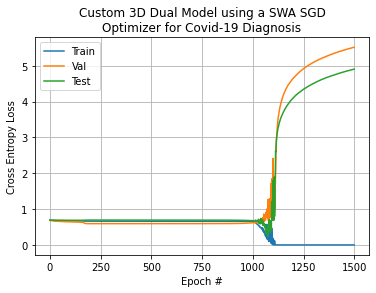

In [102]:
losses = getCNNdata("loss")

plt.plot(np.arange(len(losses["train"])), losses["train"], label="Train")
plt.plot(np.arange(len(losses["val"])), losses["val"], label="Val")
plt.plot(np.arange(len(losses["test"])), losses["test"], label="Test")
plt.legend(loc="upper left")
plt.xticks(np.arange(0, 1501, 250))
plt.xlabel("Epoch #")
plt.ylabel("Cross Entropy Loss")
plt.grid(True)
plt.title("Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis")

Text(0.5, 1.0, 'Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis')

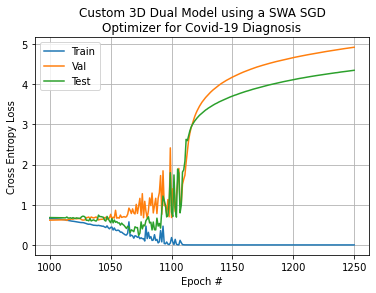

In [104]:
losses = getCNNdata("loss", 1000, 1251)

plt.plot(np.arange(len(losses["train"])), losses["train"], label="Train")
plt.plot(np.arange(len(losses["val"])), losses["val"], label="Val")
plt.plot(np.arange(len(losses["test"])), losses["test"], label="Test")
plt.legend(loc="upper left")
plt.xticks(np.arange(0, 251, 50), np.arange(1000, 1251, 50))
plt.xlabel("Epoch #")
plt.ylabel("Cross Entropy Loss")
plt.grid(True)
plt.title("Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis")

Text(0.5, 1.0, 'Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis')

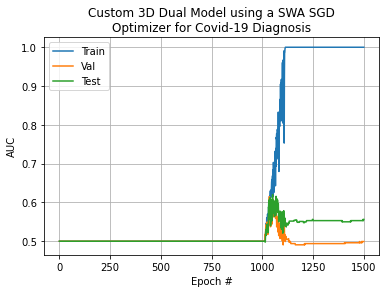

In [107]:
aucs = getCNNdata("auc")

plt.plot(np.arange(len(aucs["train"])), aucs["train"], label="Train")
plt.plot(np.arange(len(aucs["val"])), aucs["val"], label="Val")
plt.plot(np.arange(len(aucs["test"])), aucs["test"], label="Test")
plt.legend(loc="upper left")
plt.xticks(np.arange(0, 1501, 250))
plt.xlabel("Epoch #")
plt.ylabel("AUC")
plt.grid(True)
plt.title("Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis")

Text(0.5, 1.0, 'Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis')

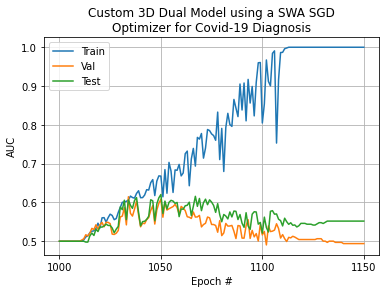

In [109]:
start = 1000
stop = 1151
step = 50

aucs = getCNNdata("auc", start, stop)

plt.plot(np.arange(len(aucs["train"])), aucs["train"], label="Train")
plt.plot(np.arange(len(aucs["val"])), aucs["val"], label="Val")
plt.plot(np.arange(len(aucs["test"])), aucs["test"], label="Test")
plt.legend(loc="upper left")
plt.xticks(np.arange(0, stop-start, step), np.arange(start, stop, step))
plt.xlabel("Epoch #")
plt.ylabel("AUC")
plt.grid(True)
plt.title("Custom 3D Dual Model using a SWA SGD\nOptimizer for Covid-19 Diagnosis")

In [ ]:
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])


def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype).to(device)
    x = F.grid_sample(x.to(device), grid).to(device)
    return x


#Test:
dtype =  torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


im = X_train[0,:].reshape(70,70,50)[:,:,0].reshape(1, 70,70,1 )
print(im.shape)
plt.imshow(im.squeeze(0)) #To plot it im should be 1 x C x H x W
plt.figure()

#Rotation by np.pi/2 with autograd support:
rotated_im = rot_img(im, np.pi/6, dtype).cpu().detach().numpy()

plt.imshow(rotated_im.squeeze(0))

In [28]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      

NameError: name 'partial' is not defined